<a href="https://colab.research.google.com/github/lucarenz1997/NLP/blob/main/Stage_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2: Transfer Learning with Advanced Open-Source Models

## Data Preparation

### Preprocessing Steps

The preprocessing steps have already been completed in the previous stage, which include:
- Dropping duplicates
- Setting data types
- Dropping unnecessary columns
- Tokenizing text data
- Stopword Removal
- Language detection
- Translating non-English text to English
- Lemmatization

These steps were applied to both datasets, `media` and `patents`, and the resulting data was saved in the `data` folder. We will now load the data and perform the following steps:

In [7]:
!pip install evaluate
!pip install cupy-cuda12x --upgrade
!pip install cugraph-cu12 --extra-index-url https://pypi.nvidia.com --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and 

In [1]:
# module imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch

print(torch.cuda.is_available())  # Should print True if GPU is present
!nvidia-smi # shows if we're using GPU

# RoBERTa
from transformers import AutoConfig, AutoModelForMaskedLM, AutoModelForSequenceClassification


In [2]:
from google.colab import drive
drive.mount('/content/drive')

processed_media_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_media_data_backup.csv")
processed_patent_data_backup = pd.read_csv("/content/drive/MyDrive/CLT/data/processed_patent_data_backup.csv")

print("Media Backup:")
processed_media_data_backup.head(5)

print("Patent Backup:")
processed_patent_data_backup.head(5)

Mounted at /content/drive
Media Backup:


,Unnamed: 0,title,date,content,domain,url,processed_text
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,chinese automotive startup XPeng show one dram...
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,Sinopec lay plan build large green hydrogen pr...
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,Huaneng Power International switch mw float pv...
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,accord iranian authority currently renewable e...
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,sign get good natural gas news datum follow to...


### Create training and validation sets for both media and patent texts.

In [3]:
# Function to preprocess data
def preprocess_data(data, seed=42):
	data = shuffle(data, random_state=seed).reset_index(drop=True)  # Shuffle and reset index with seed
	data = data.dropna().drop_duplicates(subset=['processed_text'])  # Drop NaN and duplicates
	return data.reset_index(drop=True)

# Preprocess media and patent data
media_data = preprocess_data(processed_media_data_backup.copy(), seed=42)
patent_data = preprocess_data(processed_patent_data_backup.copy(), seed=42)

# Split the data into training and validation sets with seed
media_train, media_val = train_test_split(media_data, test_size=0.2, random_state=42)
patent_train, patent_val = train_test_split(patent_data, test_size=0.2, random_state=42)

# Display sample data
print("Media Train:")
media_train.head(5) #notice how the index is reset after shuffling

Media Train:


,Unnamed: 0,title,date,content,domain,url,processed_text
12565,63589,Second Westbridge Alberta Project Wins Approval,2023-06-07,['The Alberta Utilities Commission ( AUC) rece...,solarindustrymag,https://solarindustrymag.com/second-westbridge...,the Alberta Utilities Commission AUC recently ...
1085,93711,Study: Bitcoin Could Achieve Zero Emissions by...,2022-09-07,['Despite all the promise of a decentralized c...,cleantechnica,https://cleantechnica.com/2022/09/07/study-bit...,despite promise decentralized currency free go...
19776,103900,Solar and PHES projects deemed ‘ critical’ in ...,2024-07-04,['The New South Wales ( NSW) government has de...,pv-tech,https://www.pv-tech.org/solar-and-pumped-hydro...,the New South Wales NSW government declare six...
9016,21606,10 Entrepreneurs Share CHF1.75 million to Tack...,2023-01-19,"[""By clicking `` Allow All '' you agree to the...",azocleantech,https://www.azocleantech.com/news.aspx?newsID=...,by click allow all agree storing cookie device...
10443,103449,Trinasolar rooftop project in Vietnam connecte...,2024-01-15,['Trinasolar has announced the grid connection...,pv-tech,https://www.pv-tech.org/industry-updates/trina...,trinasolar announce grid connection MW rooftop...


## Transfer Learning with Advanced Open-Source Models
- Implement transfer learning by fine-tuning pre-trained open-source models such as RoBERTa, XLNet, Longformer, FLAN-T5, and BART on the text data. Evaluate the model performance using intrinsic measures (e.g., word similarity, clustering quality) before and after fine-tuning. Analyze and quantify the insights gained from the fine-tuned model regarding emerging trends and innovation gaps in cleantech.
- Compare the performance of transfer learning with the in-house embeddings.
This comparison could be done through evaluating the effectiveness of the embeddings in domain-specific tasks like topic classification.

### RoBERTa
Is an optimized BERT approach, generally good at capturing domain-specific language. So once we have fine-tuned this, we can better recognize domain jargon

#### Load Model

In [5]:
model_name = "roberta-base"

# For masked language modeling (MLM) or domain adaptation:
config = AutoConfig.from_pretrained(model_name)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name, config=config)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

## Fine-Tuning

In [16]:
from datasets import Dataset
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
from evaluate import load
# --------------------------------------------------
# 1. Load/Instantiate Your MLM Model (RoBERTa)
# --------------------------------------------------
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name)

# --------------------------------------------------
# 2. Load the RoBERTa tokenizer
# --------------------------------------------------
roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)

# --------------------------------------------------
# 3. Define a function to re-join your words and apply RoBERTa subword tokenization
# --------------------------------------------------
def tokenize_roberta(batch):
    # 'processed_text' is a list of individual tokens, e.g. ["renewable", "energy", "innovation"]
    joined_texts = [" ".join(words) for words in batch["processed_text"]]
    return roberta_tokenizer(
        joined_texts,
        padding="max_length",
        truncation=True,
        max_length=256
    )

# --------------------------------------------------
# 4. Apply the tokenization to train/val sets
#    (Assuming media_train and media_val are HF datasets
#     or similar data structures that support .map)
# --------------------------------------------------
hf_train = hf_train.map(tokenize_roberta, batched=True)
hf_val   = hf_val.map(tokenize_roberta, batched=True)

# --------------------------------------------------
# 5. Create a data collator specialized for MLM
#    This will randomly mask tokens during training.
# --------------------------------------------------
data_collator = DataCollatorForLanguageModeling(
    tokenizer=roberta_tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# --------------------------------------------------
# 6. Define your training arguments
# --------------------------------------------------
training_args = TrainingArguments(
    output_dir="./checkpoints_roberta_mlm",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=12,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_steps=500,
    save_steps=2000,
)

# --------------------------------------------------
# 7. Build the Trainer
# --------------------------------------------------
trainer = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=hf_train,
    eval_dataset=hf_val,
    data_collator=data_collator
)

# --------------------------------------------------
# 8. Fine-tune (Train) the Model
# --------------------------------------------------
trainer.train()
trainer.save_model("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model")




Map:   0%|          | 0/16050 [00:00<?, ? examples/s]

Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

Due to time & resource limitations, we have decided to only use 2 epochs and a tokenizer max length of 256 as it would take otherwise multiple hours to train the model

#### Evaluation
##### Check Perplexity
A lower perplexity indicates that our model is better at predicting masked tokens in your domain text.

If perplexity is extremely high (for example > 100), the model is struggling.

In [18]:
import math

eval_results = trainer.evaluate()
eval_loss = eval_results["eval_loss"]
perplexity = math.exp(eval_loss)

print(f"Validation Loss: {eval_loss:.4f}")
print(f"Validation Perplexity: {perplexity:.4f}")

Validation Loss: 0.4155
Validation Perplexity: 1.5151


Interpretation: Results are quite good and indicate that our masked language model is confident and accurate in predicting masked tokens on our domain text.

##### Word Similarity


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlm_model.to(device)
mlm_model.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [59]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_word_embedding(text: str, tokenizer, model, device):
    """
    Extracts the final-layer [CLS] (or first token) embedding
    from the MLM model for a single word or phrase.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # tuple of all layers
        last_hidden_state = hidden_states[-1]  # final layer
        embedding = last_hidden_state[0, 0, :] # [CLS] token

    return embedding

Pairwise Cosine Similarities:

Similarity(hydrogen, hydrogen) = 1.0000
Similarity(hydrogen, solar) = 0.9995
Similarity(hydrogen, battery) = 0.9996
Similarity(hydrogen, wind) = 0.9994
Similarity(hydrogen, ammonia) = 0.9996
Similarity(hydrogen, oil) = 0.9994
Similarity(hydrogen, nuclear) = 0.9995
Similarity(hydrogen, electric) = 0.9991
Similarity(hydrogen, environment) = 0.9993

Similarity(solar, hydrogen) = 0.9995
Similarity(solar, solar) = 1.0000
Similarity(solar, battery) = 0.9995
Similarity(solar, wind) = 0.9994
Similarity(solar, ammonia) = 0.9994
Similarity(solar, oil) = 0.9993
Similarity(solar, nuclear) = 0.9994
Similarity(solar, electric) = 0.9990
Similarity(solar, environment) = 0.9991

Similarity(battery, hydrogen) = 0.9996
Similarity(battery, solar) = 0.9995
Similarity(battery, battery) = 1.0000
Similarity(battery, wind) = 0.9994
Similarity(battery, ammonia) = 0.9996
Similarity(battery, oil) = 0.9994
Similarity(battery, nuclear) = 0.9995
Similarity(battery, electric) = 0.9991
S

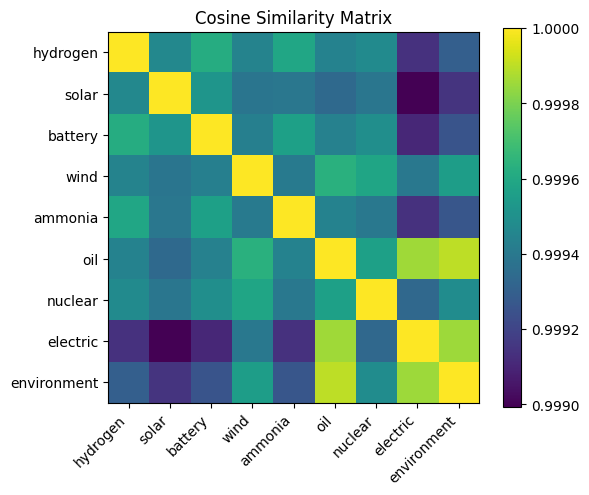

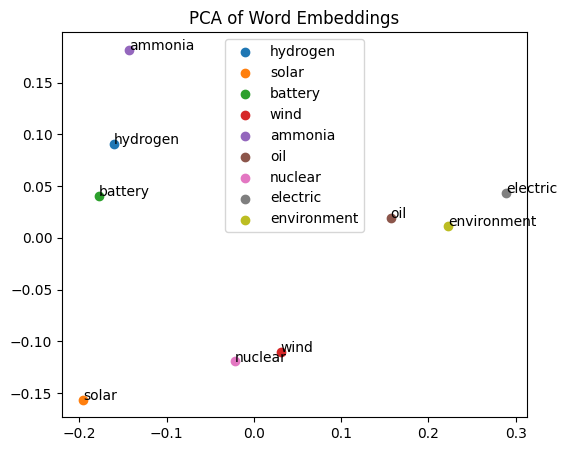

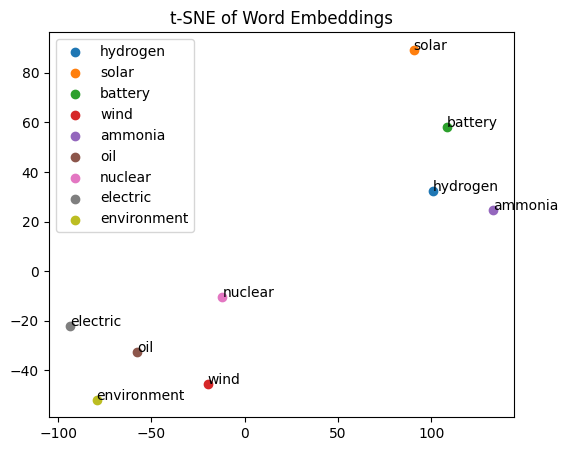

In [60]:
# Defined domain terms
domain_terms = ["hydrogen", "solar", "battery", "wind", "ammonia", "oil", "nuclear", "electric", "environment"]

# 2) Retrieve embeddings for each term
embeddings = {}
for term in domain_terms:
    embeddings[term] = get_word_embedding(term, roberta_tokenizer, mlm_model, device)

# 3) Compute and print pairwise similarities
print("Pairwise Cosine Similarities:\n")
for t1 in domain_terms:
    for t2 in domain_terms:
        sim = F.cosine_similarity(
            embeddings[t1].unsqueeze(0),
            embeddings[t2].unsqueeze(0)
        )
        print(f"Similarity({t1}, {t2}) = {sim.item():.4f}")
    print()

# 4) Create an NxN similarity matrix for a heatmap
n = len(domain_terms)
similarity_matrix = np.zeros((n, n), dtype=np.float32)

for i, t1 in enumerate(domain_terms):
    for j, t2 in enumerate(domain_terms):
        sim = F.cosine_similarity(
            embeddings[t1].unsqueeze(0),
            embeddings[t2].unsqueeze(0)
        )
        similarity_matrix[i, j] = sim.item()

# 5) Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
fig.colorbar(cax)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(domain_terms, rotation=45, ha='right')
ax.set_yticklabels(domain_terms)
ax.set_title("Cosine Similarity Matrix")
plt.tight_layout()
plt.show()

# 6) Convert embeddings to 2D arrays for PCA and t-SNE
vectors = []
for w in domain_terms:
    emb = embeddings[w]
    if emb.is_cuda:
        emb = emb.cpu()
    vectors.append(emb.numpy())
vectors_np = np.stack(vectors, axis=0)  # shape: [num_words, embedding_dim]

# 7) PCA Visualization
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(vectors_np)

plt.figure(figsize=(6, 5))
for i, w in enumerate(domain_terms):
    x, y = pca_2d[i, 0], pca_2d[i, 1]
    plt.scatter(x, y, label=w)
    plt.annotate(w, (x, y))
plt.title("PCA of Word Embeddings")
plt.legend()
plt.show()

# 8) t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
tsne_2d = tsne.fit_transform(vectors_np)

plt.figure(figsize=(6, 5))
for i, w in enumerate(domain_terms):
    x, y = tsne_2d[i, 0], tsne_2d[i, 1]
    plt.scatter(x, y, label=w)
    plt.annotate(w, (x, y))
plt.title("t-SNE of Word Embeddings")
plt.legend()
plt.show()


As it can be seen here, each word pair has a similarity of almost 1 which means that our model is not differentiating single-word inputs very much. However, we check the visualisation for further information ...

After plotting the single-word embeddings of ["hydrogen", "solar", "battery", "wind", "ammonia", "oil"], we see:

1. **Distinct Positions in 2D**  
   - Even though we observed extremely high cosine similarities (≥ 0.999) among all tokens in their native high-dimensional space, these 2D projections reveal each token is placed uniquely.  
   - This indicates the model does encode subtle distinctions at the single-token level, even if they look numerically very close in 768-dimensional space (typical for RoBERTa/BERT).

2. **Differences Between PCA and t-SNE**  
   - **PCA** is a linear method. It uncovers principal directions of variance, so words like “hydrogen”, “ammonia”, or “wind” spread out along different axes.  
   - **t-SNE** is non-linear and focuses on preserving local distances, which can lead to a very different layout. For instance, “ammonia” and “wind” might appear far apart in t-SNE because the algorithm emphasizes clustering details differently than PCA.

3. **Why the Embeddings Seem Close Yet Plotted Apart**  
   - High cosine similarity for single tokens indicates minimal variation in the final-layer vector. But **tiny differences in 768D** can become amplified when projected to 2D.  
   - Additionally, t-SNE doesn’t map distance 1-to-1 with cosine; it tries to place similar points together while spreading out dissimilar points, sometimes exaggerating separation for clarity.

In summary, **both visualizations confirm** there is some inherent semantic distinction in how the model represents these energy-related terms, but single-token embeddings remain very close overall—particularly in the final layer specialized for masked language modeling.

Pairwise Cosine Similarities:

Similarity(hydrogen, hydrogen) = 1.0000
Similarity(hydrogen, solar) = 0.9995
Similarity(hydrogen, battery) = 0.9996
Similarity(hydrogen, wind) = 0.9994
Similarity(hydrogen, ammonia) = 0.9996
Similarity(hydrogen, oil) = 0.9994
Similarity(hydrogen, abatement) = 0.9992
Similarity(hydrogen, absorption) = 0.9995
Similarity(hydrogen, aerodynamics) = 0.9997
Similarity(hydrogen, aerosol) = 0.9991
Similarity(hydrogen, agroforestry) = 0.9998
Similarity(hydrogen, airflow) = 0.9997
Similarity(hydrogen, algae) = 0.9995
Similarity(hydrogen, brownfield) = 0.9997
Similarity(hydrogen, chromium) = 0.9997
Similarity(hydrogen, climate) = 0.9996
Similarity(hydrogen, cogeneration) = 0.9994
Similarity(hydrogen, combustion) = 0.9991
Similarity(hydrogen, environmental) = 0.9996
Similarity(hydrogen, exhaust) = 0.9995
Similarity(hydrogen, forestry) = 0.9997
Similarity(hydrogen, fossil) = 0.9995
Similarity(hydrogen, harvest) = 0.9997
Similarity(hydrogen, heating) = 0.9997
Similarity

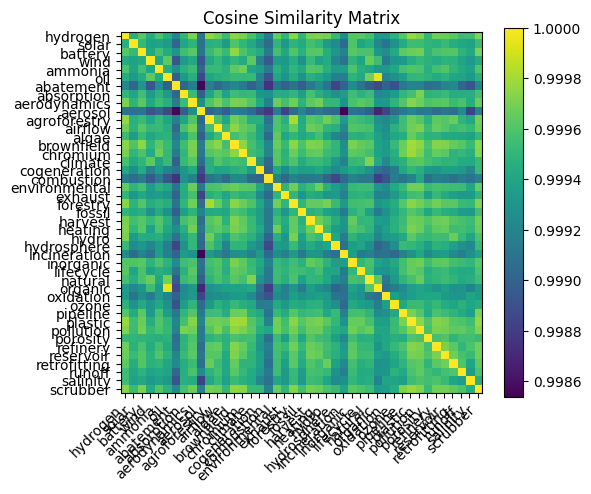

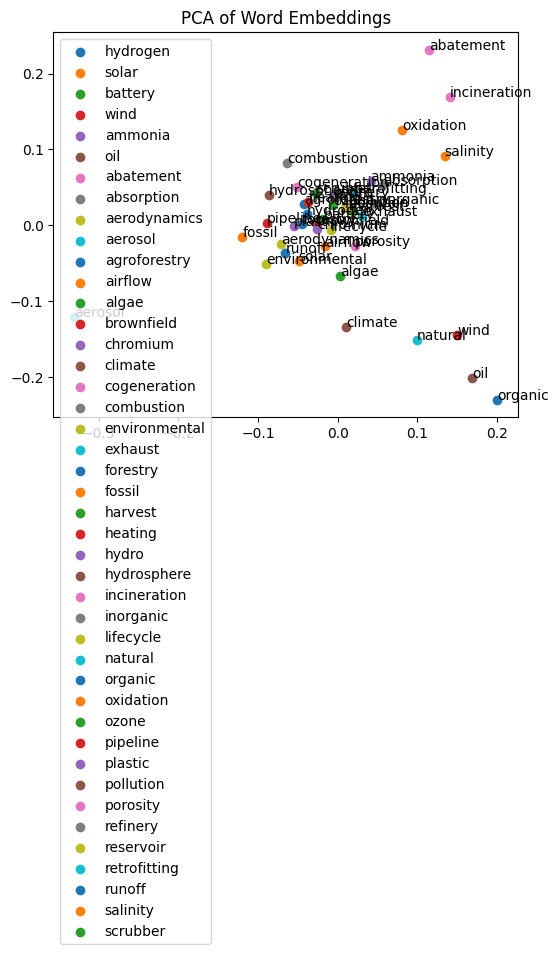

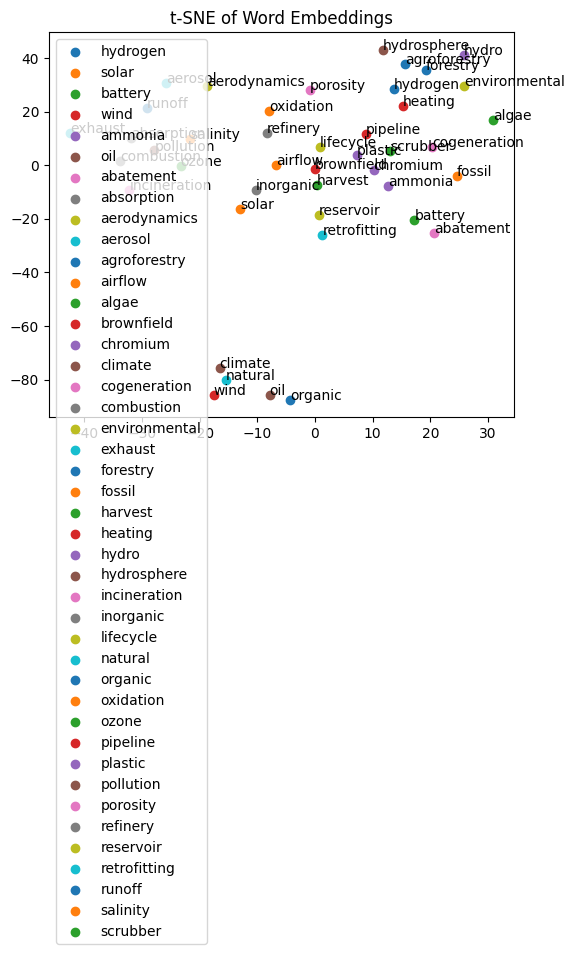

In [61]:
# We try it now with rougly 100 terms to see if clustering looks good.

# 1) Define your domain terms
domain_terms = ["hydrogen", "solar", "battery", "wind", "ammonia", "oil"]

other_terms = [
    "abatement",
    "absorption",
    "aerodynamics",
    "aerosol",
    "agroforestry",
    "airflow",
    "algae",
    "brownfield",
    "chromium",
    "climate",
    "cogeneration",
    "combustion",
    "environmental",
    "exhaust",
    "forestry",
    "fossil",
    "harvest",
    "heating",
    "hydro",
    "hydrosphere",
    "incineration",
    "inorganic",
    "lifecycle",
    "natural",
    "organic",
    "oxidation",
    "ozone",
    "pipeline",
    "plastic",
    "pollution",
    "porosity",
    "refinery",
    "reservoir",
    "retrofitting",
    "runoff",
    "salinity",
    "scrubber"
]




terms = domain_terms + other_terms

# 2) Retrieve embeddings for each term
embeddings = {}
for term in terms:
    embeddings[term] = get_word_embedding(term, roberta_tokenizer, mlm_model, device)

# 3) Compute and print pairwise similarities
print("Pairwise Cosine Similarities:\n")
for t1 in terms:
    for t2 in terms:
        sim = F.cosine_similarity(
            embeddings[t1].unsqueeze(0),
            embeddings[t2].unsqueeze(0)
        )
        print(f"Similarity({t1}, {t2}) = {sim.item():.4f}")
    print()

# 4) Create an NxN similarity matrix for a heatmap
n = len(terms)
similarity_matrix = np.zeros((n, n), dtype=np.float32)

for i, t1 in enumerate(terms):
    for j, t2 in enumerate(terms):
        sim = F.cosine_similarity(
            embeddings[t1].unsqueeze(0),
            embeddings[t2].unsqueeze(0)
        )
        similarity_matrix[i, j] = sim.item()

# 5) Plot the heatmap
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
fig.colorbar(cax)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(terms, rotation=45, ha='right')
ax.set_yticklabels(terms)
ax.set_title("Cosine Similarity Matrix")
plt.tight_layout()
plt.show()

# 6) Convert embeddings to 2D arrays for PCA and t-SNE
vectors = []
for w in terms:
    emb = embeddings[w]
    if emb.is_cuda:
        emb = emb.cpu()
    vectors.append(emb.numpy())
vectors_np = np.stack(vectors, axis=0)  # shape: [num_words, embedding_dim]

# 7) PCA Visualization
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(vectors_np)

plt.figure(figsize=(6, 5))
for i, w in enumerate(terms):
    x, y = pca_2d[i, 0], pca_2d[i, 1]
    plt.scatter(x, y, label=w)
    plt.annotate(w, (x, y))
plt.title("PCA of Word Embeddings")
plt.legend()
plt.show()

# 8) t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
tsne_2d = tsne.fit_transform(vectors_np)

plt.figure(figsize=(6, 5))
for i, w in enumerate(terms):
    x, y = tsne_2d[i, 0], tsne_2d[i, 1]
    plt.scatter(x, y, label=w)
    plt.annotate(w, (x, y))
plt.title("t-SNE of Word Embeddings")
plt.legend()
plt.show()





##### Clustering Measures
As clustering with a very small samples removes the statistical aspect, we apply the clustering measures only to the ones with lots of terms

Silhouette Score: 0.0882


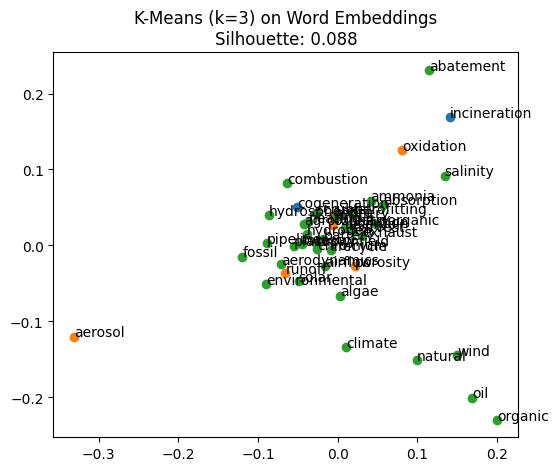

In [68]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

words = list(embeddings.keys())

# Convert embeddings to a 2D NumPy array: [num_words, embedding_dim]
vectors = []
for w in words:
    emb_tensor = embeddings[w]  # a 1D PyTorch tensor
    if emb_tensor.is_cuda:
        emb_tensor = emb_tensor.cpu()
    vectors.append(emb_tensor.numpy())
vectors_np = np.stack(vectors, axis=0)

#############################################
# 2. K-Means Clustering
#############################################

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(vectors_np)
cluster_labels = kmeans.labels_

#############################################
# 3. Compute Clustering Quality via Silhouette Score
#############################################

# Silhouette ranges from -1 to +1
# +1 => perfectly separated clusters
# near 0 => overlapping clusters
# -1 => clusters are assigned incorrectly
sil_score = silhouette_score(vectors_np, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

#############################################
# 4. Quick 2D Visualization
#############################################
# We'll do a simple PCA or t-SNE to see how the clusters look in 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(vectors_np)

plt.figure(figsize=(6, 5))
for i, w in enumerate(words):
    x, y = pca_2d[i, 0], pca_2d[i, 1]
    plt.scatter(x, y, c=f"C{cluster_labels[i]}")
    plt.annotate(w, (x, y))

plt.title(f"K-Means (k={num_clusters}) on Word Embeddings\nSilhouette: {sil_score:.3f}")
plt.show()


# Compare

##Defintions

In [106]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_word_embedding(text: str, tokenizer, model, device):
    """
    Extracts the final-layer [CLS] (or first token) embedding
    from the model for a single word or phrase.

    Note: For AutoModelForMaskedLM, we request output_hidden_states=True.
    For AutoModel, the output already contains last_hidden_state.
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # Request hidden states from the model.
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states  # tuple of all layers
        last_hidden_state = hidden_states[-1]    # final layer
        embedding = last_hidden_state[0, 0, :]     # use the [CLS] token

    return embedding

def get_embeddings_for_terms(terms, tokenizer, model, device):
    embeddings = {}
    for term in terms:
        embeddings[term] = get_word_embedding(term, tokenizer, model, device)
    return embeddings

def visualize_embeddings(embeddings, title_suffix="", k=5):
    terms = list(embeddings.keys())

    # ----- A) Pairwise Similarities (printed) -----
    print("Pairwise Cosine Similarities:\n")
    for t1 in terms:
        for t2 in terms:
            sim = F.cosine_similarity(
                embeddings[t1].unsqueeze(0),
                embeddings[t2].unsqueeze(0)
            )


    # ----- B) Similarity Matrix Heatmap -----
    n = len(terms)
    similarity_matrix = np.zeros((n, n), dtype=np.float32)
    for i, t1 in enumerate(terms):
        for j, t2 in enumerate(terms):
            sim = F.cosine_similarity(
                embeddings[t1].unsqueeze(0),
                embeddings[t2].unsqueeze(0)
            )
            similarity_matrix[i, j] = sim.item()

    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(terms, rotation=45, ha='right')
    ax.set_yticklabels(terms)
    ax.set_title("Cosine Similarity Matrix " + title_suffix)
    plt.tight_layout()
    plt.show()

    # ----- C) Convert embeddings to 2D NumPy array -----
    vectors = []
    for w in terms:
        emb = embeddings[w]
        if emb.is_cuda:
            emb = emb.cpu()
        vectors.append(emb.numpy())
    vectors_np = np.stack(vectors, axis=0)  # shape: [num_terms, embedding_dim]

    # ----- D) Knee (Elbow) Plot for K-Means Inertia -----
    ks = list(range(2, 11))  # testing cluster numbers 2 to 10
    inertias = []
    for k_val in ks:
        kmeans_temp = KMeans(n_clusters=k_val, random_state=42)
        kmeans_temp.fit(vectors_np)
        inertias.append(kmeans_temp.inertia_)

    plt.figure(figsize=(6, 5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.title("Elbow/Knee Plot " + title_suffix)
    plt.xticks(ks)
    plt.show()

    # ----- E) PCA Visualization -----
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, label=w)
        plt.annotate(w, (x, y))
    plt.title("PCA of Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # ----- F) t-SNE Visualization -----
    tsne = TSNE(n_components=2, perplexity=3, random_state=42)
    tsne_2d = tsne.fit_transform(vectors_np)

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = tsne_2d[i, 0], tsne_2d[i, 1]
        plt.scatter(x, y, label=w)
        plt.annotate(w, (x, y))
    plt.title("t-SNE of Embeddings " + title_suffix)
    plt.legend()
    plt.show()

    # ----- G) K-Means Clustering & Silhouette Score -----
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors_np)
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(vectors_np, cluster_labels)
    print(f"K-Means (k={k}) Silhouette Score {title_suffix}: {sil_score:.4f}")

    plt.figure(figsize=(6, 5))
    for i, w in enumerate(terms):
        x, y = pca_2d[i, 0], pca_2d[i, 1]
        plt.scatter(x, y, c=f"C{cluster_labels[i]}")
        plt.annotate(w, (x, y))
    plt.title(f"K-Means Clustering (k={k}) {title_suffix}\nSilhouette: {sil_score:.3f}")
    plt.show()

# Example usage:
# (Assuming you already have a dictionary "embeddings" computed for a set of terms)
# visualize_embeddings(embeddings, title_suffix="(Example)", k=5)


## Load models

In [91]:
# -----------------------------
# 4. Set up: load models, tokenizer, and device
# -----------------------------
model_name = "roberta-base"

# Load the fine-tuned MLM model (assume you already fine-tuned it)
from transformers import AutoModelForMaskedLM, AutoModel, AutoTokenizer, AutoConfig
from transformers import DataCollatorForLanguageModeling, TrainingArguments, Trainer
# Fine-tuned model:
mlm_model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/CLT/data/fine_tuned_roberta_model")
# Base model (for embeddings, we use AutoModel):
base_model = AutoModel.from_pretrained(model_name)

roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlm_model.to(device)
base_model.to(device)
mlm_model.eval()
base_model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [107]:
# -----------------------------
# 5. Define the terms to compare (domain terms + any other terms if needed)
# -----------------------------
domain_terms = ["hydrogen", "solar", "battery", "wind", "ammonia", "oil", "nuclear", "electric", "environment", "water", "fire", "engine", "river",     "abatement",

    "climate",
    "cogeneration",
    "hydrosphere",
    "incineration",
    "inorganic",
    "lifecycle",
    "natural",
    "organic",
    "oxidation",
    "ozone",
    "pipeline",
    "plastic",
    "pollution"
   ]

# -----------------------------
# 6. Get embeddings for each model
# -----------------------------
print("Computing embeddings with Base Model...")
embeddings_base = get_embeddings_for_terms(domain_terms, roberta_tokenizer, base_model, device)

print("Computing embeddings with Fine-Tuned Model...")
embeddings_finetuned = get_embeddings_for_terms(domain_terms, roberta_tokenizer, mlm_model, device)

Computing embeddings with Base Model...
Computing embeddings with Fine-Tuned Model...



=== Results from Base Model ===
Pairwise Cosine Similarities:



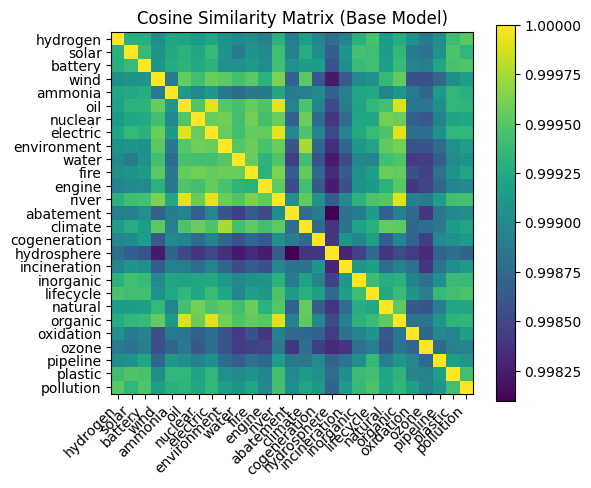

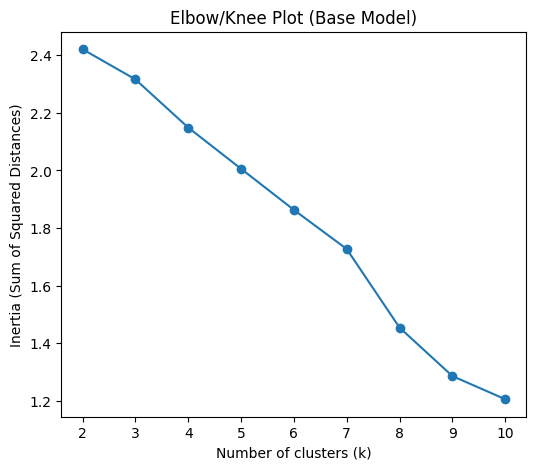

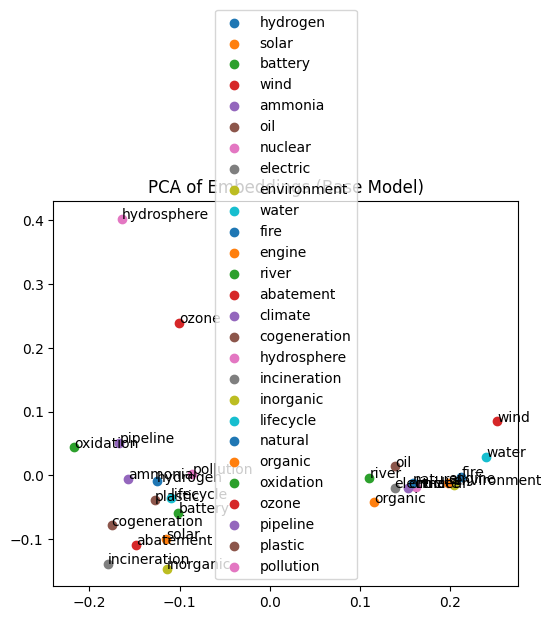

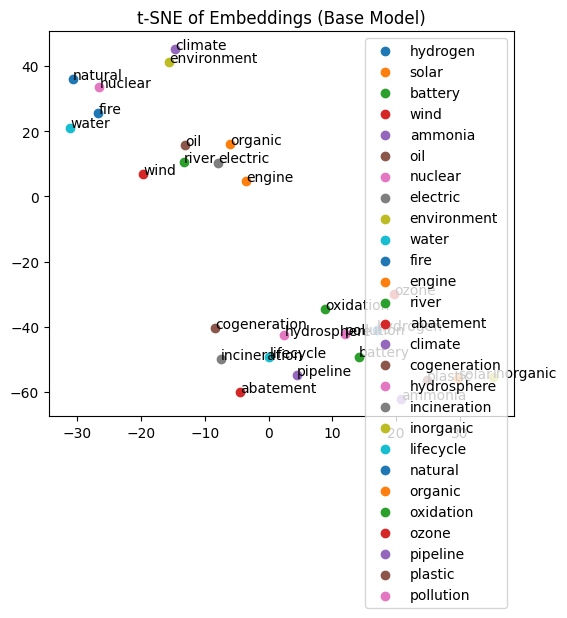

K-Means (k=8) Silhouette Score (Base Model): 0.0770


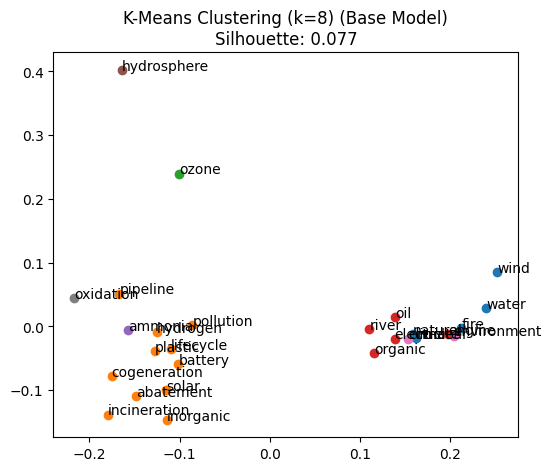

In [110]:
n_clusters = 8
# -----------------------------
# 7. Visualize and compare results for the Base Model
# -----------------------------
print("\n=== Results from Base Model ===")
visualize_embeddings(embeddings_base, title_suffix="(Base Model)", k=n_clusters)


=== Results from Fine-Tuned Model ===
Pairwise Cosine Similarities:



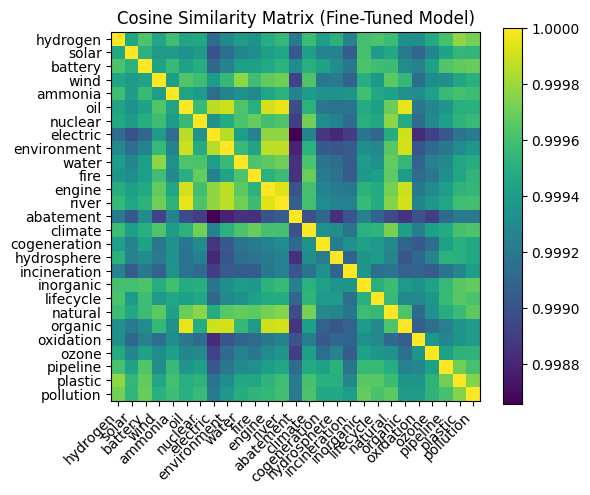

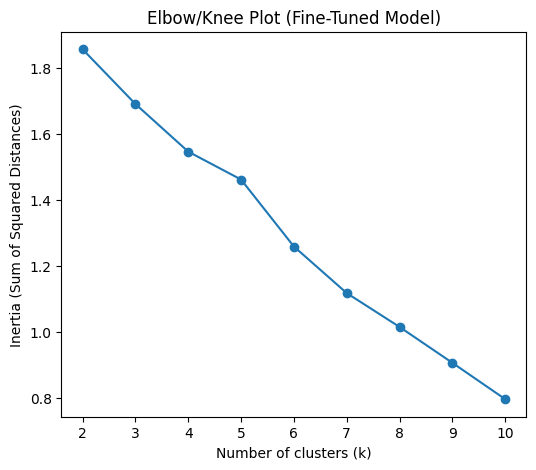

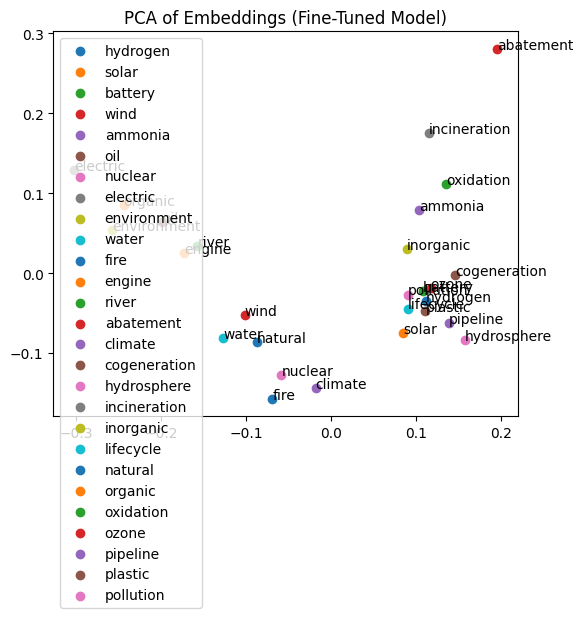

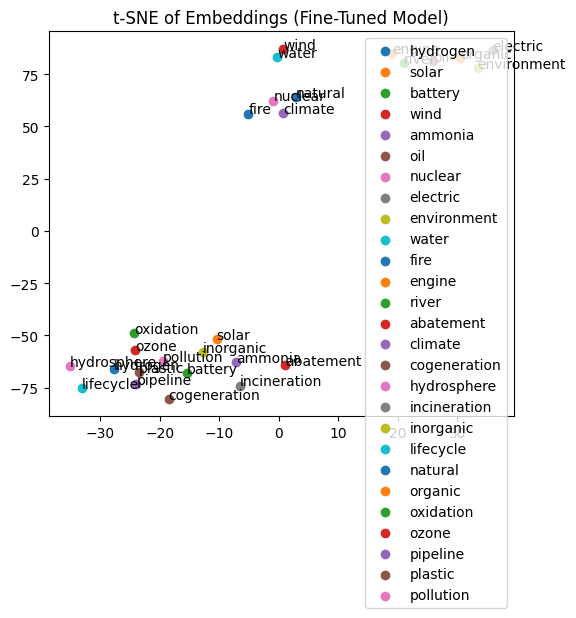

K-Means (k=8) Silhouette Score (Fine-Tuned Model): 0.1448


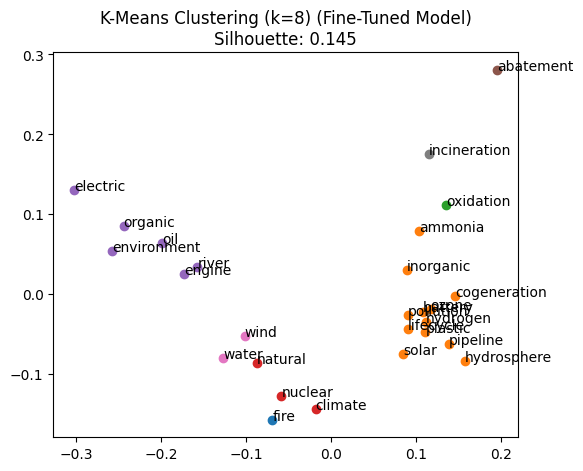

In [111]:
# -----------------------------
# 8. Visualize and compare results for the Fine-Tuned Model
# -----------------------------
print("\n=== Results from Fine-Tuned Model ===")
visualize_embeddings(embeddings_finetuned, title_suffix="(Fine-Tuned Model)", k=n_clusters)